# Financial and Accounting Analytics of Stock Returns during Covid-19 Pandemic in 2020

In 2020, which is considered to be one of the worst year among decades, encountered a great economic recession. Stock market unprecedentedly plunged over 30% in mid-March, which terrified most of the investors. Yet surprisingly, full recovery prevailed right after several circuit brakes of stock, which has been regarded as an 'abnormal phenomenon' by some experts. Among the post-pandemic stock market, what is worthwhile to notice is that overall return varies across companies. Some stocks reached all time high in the rest of the year while others still lagging behind S&P500. Difference of stock returns are mostly driven by actions from the one own the stocks, investors. Stockholders will purchase more stock of company if they are confident on that firm, and vice versa. Various issues may effects investors' confidence, though. Financial health of a company could be one of those. In this project, we strive to figure out how financial ratios in 2019 influence stock return in 2020 at the industry level. We measure financial data from fiscal year 2019 since it is the only visible report for investors in early 2020.

Outline:
*   Collect stock data including financial ratio, industries, and stock performance. Prepare all data for analysis

*   Separate stock return into two terms, Jaunary-March and April-December given that the lowest point in 52-weeks locates in March. Label each return by RetEarly2020 and RetLate2020 respectively

*   Group stocks into industries by several criteria (SIC, NAICS, GSECTOR, and GGROUP). Measure which method generates best sectors by adjusted-r-square, distribution of companies among each industry, and numbers of industries in total.

*   Select financial ratio with top 10 largest absolute correlations with stock return. Run linear regression by utilizing top 10 values as x and by using stock return as y. Discover which shows statistical significance.

*   Solict industry with the most polarized stock performance. Collect their key financial variables (which are statistically significant) respectively for return early and return late. Measure how key financial variables relates to stock returns among these industries.

## Data Preparation

In [ ]:
# Import module
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import scipy.stats as st
import re
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Read dataset with all financial data from 2019 fiscal year.

In [ ]:
finance_data = pd.read_csv('BA870 project data.csv')

In [ ]:
finance_data.head()

,datadate,tic,act,ap,at,ceq,ch,cogs,csho,dltt,ebit,emp,fatd,fincf,lct,lt,ni,ppent,re,revt,sale,tie,prcc_c,ggroup,gsector,naics,sic
0,20200531,AIR,1438.700,191.600,2079.000,902.600,404.700,1726.700,35.097,670.900,108.400,5.40,NaN,444.500,383.100,1176.400,4.400,437.100,661.400,2089.300,2089.300,NaN,45.10,2010,20,423860,5080
1,20191231,AAL,8206.000,2062.000,59995.000,-118.000,280.000,32027.000,428.203,28875.000,3706.000,133.70,NaN,-1568.000,18311.000,60113.000,1686.000,43732.000,-4067.000,45768.000,45768.000,NaN,28.68,2030,20,481111,4512
2,20191231,CECE,179.498,48.762,408.637,193.017,35.602,225.660,35.137,81.457,19.622,0.83,NaN,-12.116,115.188,215.620,17.707,28.881,-60.849,341.869,341.869,NaN,7.66,2020,20,333413,3564
3,20191231,PNW,1030.030,346.448,18479.247,5430.648,10.283,2208.320,112.436,4884.430,671.960,6.21,NaN,178.768,2078.365,12926.059,538.320,14377.787,2780.514,3471.209,3471.209,NaN,89.93,5510,55,2211,4911
4,20191231,PRG,NaN,89.959,3297.800,1737.259,57.755,137.253,66.718,626.530,313.931,12.10,NaN,-168.552,NaN,1560.541,31.472,1986.294,2029.594,3947.656,3947.656,NaN,57.11,4020,40,522220,6141


Dataset may contain several missing values. We visualize them with heatmap. We drop columns with lots of missing values but keep those with few. Next, we drop rows with null values.

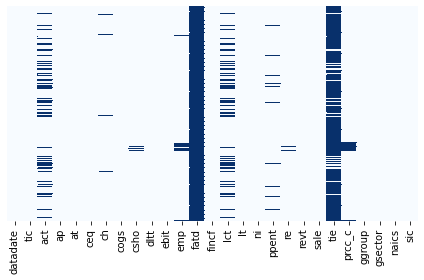

In [ ]:
# Missing values before dropping the column
#cmap = sns.cm.rocket_r
sns.heatmap(finance_data.isnull(),yticklabels=False,cbar=False, cmap='Blues')
plt.tight_layout()
plt.savefig('raw heatmap.jpeg');

In [ ]:
# Drop columns with lots of missing values
finance_data.drop(columns=['act', 'lct', 'fatd', 'tie', 'ppent'], inplace= True)

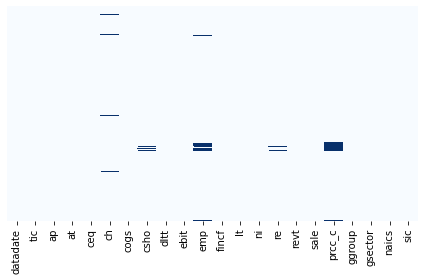

In [ ]:
# Missing values after dropping columns
sns.heatmap(finance_data.isnull(),yticklabels=False,cbar=False, cmap='Blues')
plt.tight_layout()
plt.savefig('heatmap 2.jpeg');

In [ ]:
print(finance_data.shape)
finance_data.dropna(inplace= True)
print(finance_data.shape)

(2838, 22)
(2608, 22)


Obervations are reduced from 2838 to 2608 after cleaning the data.

Next, we will rename all industry indicators, including sic, naisc, gsector and ggroup.

In [ ]:
# Label industry indicators: rename sic
finance_data['sic'] = (finance_data['sic']/100).apply(np.floor)

def f(row):
  if row['sic'] <= 9:
    val = 'Agriculture, Forestry, Fishing'
  elif (row['sic'] >= 10) & (row['sic'] <= 14):
    val = 'Mining'
  elif (row['sic'] >= 15) & (row['sic'] <= 17):
    val = 'Construction'
  elif (row['sic'] >= 20) & (row['sic'] <= 39):
    val = 'Manufacturing'
  elif (row['sic'] >= 40) & (row['sic'] <= 49):
    val = 'Transportation & Public Utilities'
  elif (row['sic'] >= 50) & (row['sic'] <= 51):
    val = 'Wholesale Trade'
  elif (row['sic'] >= 52) & (row['sic'] <= 59):
    val = 'Retail Trade'
  elif (row['sic'] >= 60) & (row['sic'] <= 67):
    val = 'Finance, Insurance, Real Estate'
  elif (row['sic'] >= 70) & (row['sic'] <= 89):
    val = 'Services' 
  elif (row['sic'] >= 91) & (row['sic'] <= 99):
    val = 'Public Administration'
  return val

finance_data['sic'] = finance_data.apply(f, axis=1)

In [ ]:
# Label industry indicators: rename naisc
finance_data['naics'] = finance_data['naics'].astype(str).str.extract(r'(\d{1,2})').astype(int)

finance_data['naics'].replace({11: 'Agriculture, Forestry, Fishing, Hunting', 21: 'Mining, Quarrying, Oil, Gas Extraction', 
                               22: 'Utilities', 23: 'Construction', 31: 'Manufacturing', 32: 'Manufacturing',
                               33: 'Manufacturing', 42: 'Wholesale Trade', 44:'Retail Trade', 45: 'Retail Trade',
                               48: 'Transportation and Warehousing', 49: 'Transportation and Warehousing', 
                               51: 'Information', 52: 'Finance and Insurance', 53: 'Real Estate, Rental, Leasing',
                               54: 'Professional, Scientific, Tech, Services', 55: 'Mgmt. of Companies & Enterprises',
                               56: 'Administrative and Support and Waste Management and Remediation Services',
                               61: 'Educational Services', 62: 'Health Care and Social Assistance', 
                               71: 'Arts, Entertainment, Recreation', 72: 'Accomodation and Food Services',
                               81: 'Other Services', 92: 'Public Administration'}, inplace = True)

In [ ]:
# Label industry indicators: rename gsector
finance_data["gsector"].replace({10: 'Energy', 15: 'Materials', 20: 'Industrials', 25: 'Consumer Discretionary',
                           30: 'Consumer Staples', 35: 'Health Care', 40:'Financials', 
                           45: 'Information Technology', 50: 'Telecommunication Services',
                           55: 'Utilities', 60: 'Real Estate'}, inplace = True)

In [ ]:
# Label industry indicators: rename ggroup
finance_data["ggroup"].replace({1010: 'Energy', 1510: 'Materials', 2010: 'Capital Goods',
                           2020: 'Commercial  & Professional Services', 2030: 'Transportation',
                           2510: 'Automobiles & Components', 2520: 'Consumer Durables & Apparel',
                           2530: 'Consumer Services', 2540: 'Media', 2550: 'Retailing', 
                           3010: 'Food & Staples Retailing', 3020: 'Food, Beverage & Tobacco',
                           3030: 'Household & Personal Products', 3510: 'Health Care Equipment & Services',
                           3520: 'Pharmaceuticals, Biotechnology & Life Sciences',
                           4010: 'Banks', 4020: 'Diversified Financials', 4030: 'Insurance',
                           4510: 'Software & Services', 4520: 'Technology Hardware & Equipment',
                           4530: 'Semiconductors & Semiconductor Equipment',
                           5010: 'Telecommunication Services', 5510: 'Utilities', 6010: 'Real Estate',
                           5020: 'Media & Entertainment'}, inplace=True)

Since our analysis also relies on stock return, we should gather related data.

In [ ]:
return_stock = pd.read_csv('temp1.csv')
return_stock = return_stock[['TICKER', 'RetEarly2020', 'RetLate2020']]
return_stock.rename(columns = {'TICKER': 'tic'}, inplace = True)

In [ ]:
return_stock.head()

,tic,RetEarly2020,RetLate2020
0,AAPL,-0.131598,1.099543
1,MSFT,0.003212,0.421139
2,AMZN,0.055135,0.670460
3,FB,-0.187333,0.637649
4,GOOGL,-0.132479,0.508361


In [ ]:
return_stock.shape

(2664, 3)

Now that we possess both financial data and stock return data, we will merge them all together.

In [ ]:
# Merge dataset
stock_raw = pd.merge(finance_data, return_stock, on='tic')

In [ ]:
stock_raw.shape

(2551, 24)

Our data is ready to go!

## Industry

In the part, we will measure which criteria is the optimal way to separate stocks by different industries. We will try SIC, NAICS, GSECTOR, and GGROUP. For each industries, data will be winsorized to adjust all outliers. After processing all four types of industry codes, we will select the best one based on three criterias: adjust-r-square, distributions of companies across industries, numbers of industries.

### SIC

In [ ]:
# Extract necessary columns
early_late_sic = stock_raw[['tic', 'sic', 'RetEarly2020', 'RetLate2020']]

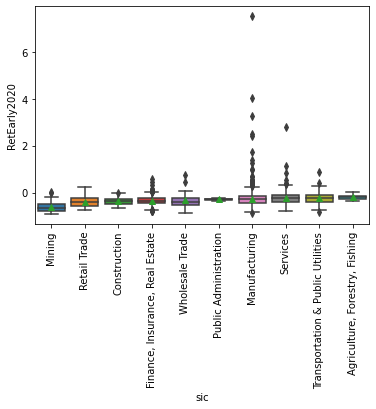

In [ ]:
# Before winsorization

# Create row order's lists
ea_order_sic = list(early_late_sic[['sic',
                              'RetEarly2020']].groupby('sic'
                              ).mean().sort_values(by = 'RetEarly2020',
                                                   ascending= True).reset_index()['sic'])

# Sort values with boxplot
sns.boxplot(x='sic', y='RetEarly2020', order= ea_order_sic, data= early_late_sic, showmeans= True)
plt.xticks(rotation=90);

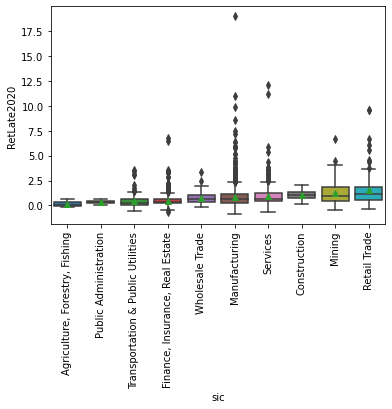

In [ ]:
# Before winsorization

# Create row order's lists
late_order_sic = list(early_late_sic[['sic',
                              'RetLate2020']].groupby('sic'
                              ).mean().sort_values(by = 'RetLate2020',
                                                   ascending= True).reset_index()['sic'])

# Sort values with boxplot
sns.boxplot(x='sic', y='RetLate2020', order =late_order_sic, data=early_late_sic, showmeans= True)
plt.xticks(rotation=90);

In [ ]:
# winsorization
early_late_sic['RetEarly2020'] = winsorize(early_late_sic['RetEarly2020'], limits=(0.02, 0.02))
early_late_sic['RetLate2020'] = winsorize(early_late_sic['RetLate2020'], limits=(0.02, 0.02))

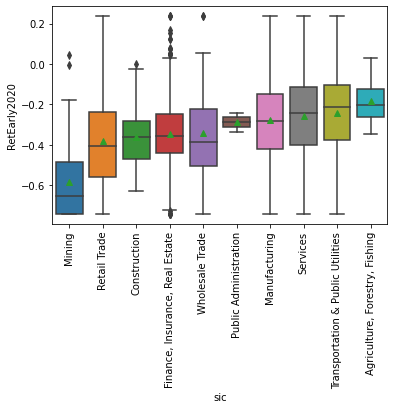

In [ ]:
# After winsorization

# Create row order's lists
ea_order_sic = list(early_late_sic[['sic',
                              'RetEarly2020']].groupby('sic'
                              ).mean().sort_values(by = 'RetEarly2020',
                                                   ascending= True).reset_index()['sic'])

# Sort values with boxplot
sns.boxplot(x='sic', y='RetEarly2020', order= ea_order_sic, data= early_late_sic, showmeans= True)
plt.xticks(rotation=90);

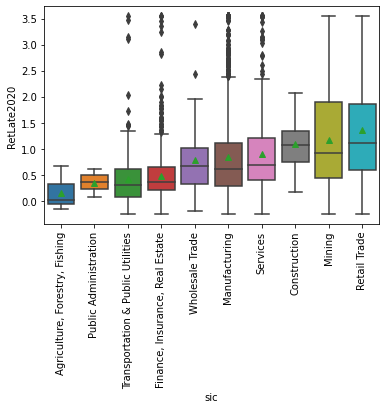

In [ ]:
# After winsorization

# Create row order's lists
late_order_sic = list(early_late_sic[['sic',
                              'RetLate2020']].groupby('sic'
                              ).mean().sort_values(by = 'RetLate2020',
                                                   ascending= True).reset_index()['sic'])

# Sort values with boxplot
sns.boxplot(x='sic', y='RetLate2020', order =late_order_sic, data=early_late_sic, showmeans= True)
plt.xticks(rotation=90);

### NAICS

In [ ]:
early_late_na = stock_raw[['tic', 'naics', 'RetEarly2020', 'RetLate2020']]

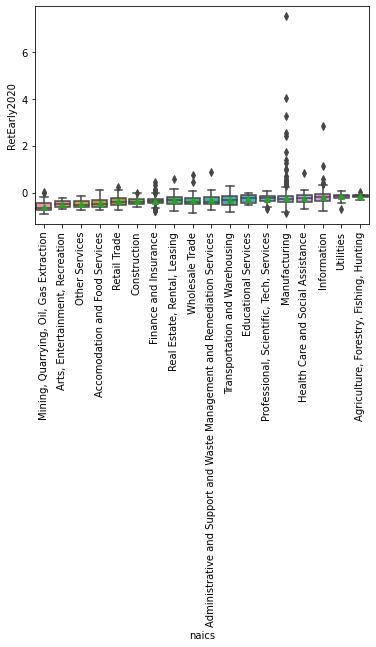

In [ ]:
# Before winsorization

# Remove unknown industry
early_late_na = early_late_na.loc[early_late_na['naics']!= 99]

# Create row order's lists
ea_order_na = list(early_late_na[['naics',
                              'RetEarly2020']].groupby('naics'
                              ).mean().sort_values(by = 'RetEarly2020',
                                                   ascending= True).reset_index()['naics'])

# Sort values with boxplot
sns.boxplot(x='naics', y='RetEarly2020', order= ea_order_na, data= early_late_na, showmeans= True)
plt.xticks(rotation=90);

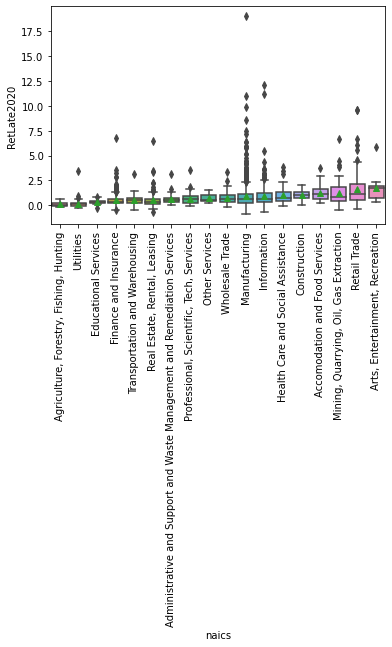

In [ ]:
# Before winsorization

# Remove unknown industry
early_late_na = early_late_na.loc[early_late_na['naics']!= 99]

# Create row order's lists
late_order_na = list(early_late_na[['naics',
                              'RetLate2020']].groupby('naics'
                              ).mean().sort_values(by = 'RetLate2020',
                                                   ascending= True).reset_index()['naics'])

# Sort values with boxplot
sns.boxplot(x='naics', y='RetLate2020', order = late_order_na, data = early_late_na, showmeans= True)
plt.xticks(rotation=90);

In [ ]:
# winsorization
early_late_na['RetEarly2020'] = winsorize(early_late_na['RetEarly2020'], limits=(0.02, 0.02))
early_late_na['RetLate2020'] = winsorize(early_late_na['RetLate2020'], limits=(0.02, 0.02))

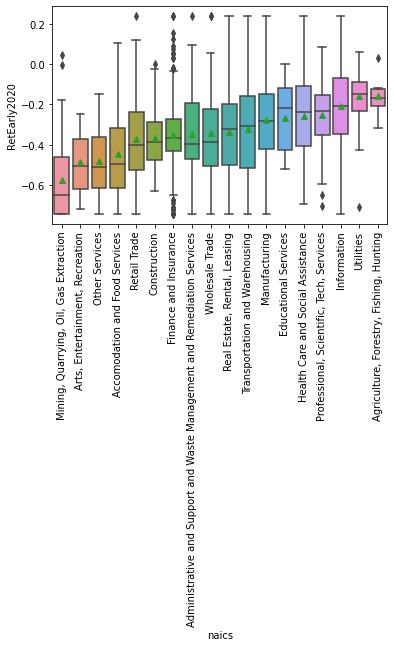

In [ ]:
# After winsorization

# Remove unknown industry
early_late_na = early_late_na.loc[early_late_na['naics']!= 99]

# Create row order's lists
ea_order_na = list(early_late_na[['naics',
                              'RetEarly2020']].groupby('naics'
                              ).mean().sort_values(by = 'RetEarly2020',
                                                   ascending= True).reset_index()['naics'])

# Sort values with boxplot
sns.boxplot(x='naics', y='RetEarly2020', order= ea_order_na, data= early_late_na, showmeans= True)
plt.xticks(rotation=90);

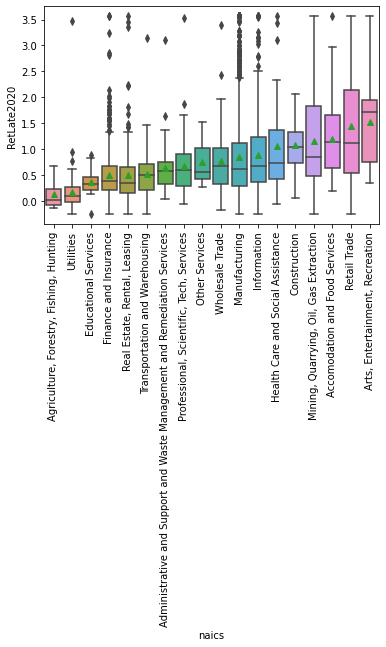

In [ ]:
# After winsorization

# Remove unknown industry
early_late_na = early_late_na.loc[early_late_na['naics']!= 99]

# Create row order's lists
late_order_na = list(early_late_na[['naics',
                              'RetLate2020']].groupby('naics'
                              ).mean().sort_values(by = 'RetLate2020',
                                                   ascending= True).reset_index()['naics'])

# Sort values with boxplot
sns.boxplot(x='naics', y='RetLate2020', order = late_order_na, data = early_late_na, showmeans= True)
plt.xticks(rotation=90);

### Gsector

In [ ]:
early_late = stock_raw[['tic', 'gsector', 'RetEarly2020', 'RetLate2020']]

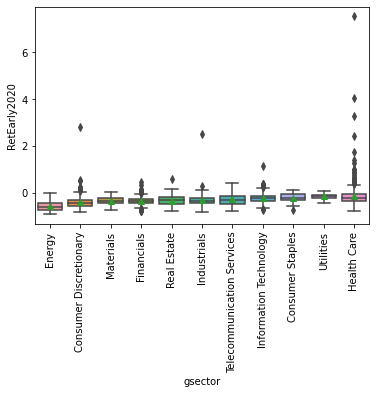

In [ ]:
# Before winsorization

# Create row order's lists
ea_order = list(early_late[['gsector',
                              'RetEarly2020']].groupby('gsector'
                              ).mean().sort_values(by = 'RetEarly2020',
                                                   ascending= True).reset_index()['gsector'])

# Sort values with boxplot
sns.boxplot(x='gsector', y='RetEarly2020', order= ea_order, data= early_late, showmeans= True)
plt.xticks(rotation=90);

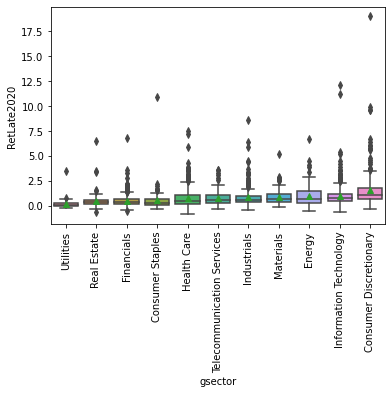

In [ ]:
# Before winsorization

# Create row order's lists
late_order = list(early_late[['gsector',
                              'RetLate2020']].groupby('gsector'
                              ).mean().sort_values(by = 'RetLate2020',
                                                   ascending= True).reset_index()['gsector'])

# Sort values with boxplot
sns.boxplot(x='gsector', y='RetLate2020', order =late_order, data=early_late, showmeans= True)
plt.xticks(rotation=90);

In [ ]:
# winsorization
early_late['RetEarly2020'] = winsorize(early_late['RetEarly2020'], limits=(0.01, 0.01))
early_late['RetLate2020'] = winsorize(early_late['RetLate2020'], limits=(0.02, 0.02))

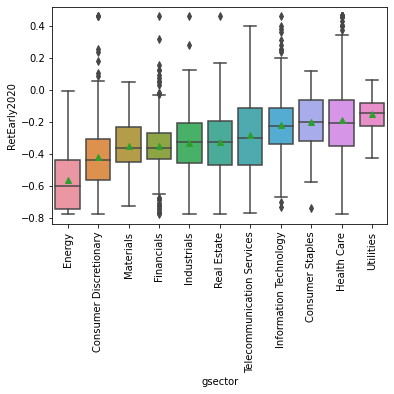

In [ ]:
# Create row order's lists
ea_order = list(early_late[['gsector',
                              'RetEarly2020']].groupby('gsector'
                              ).mean().sort_values(by = 'RetEarly2020',
                                                   ascending= True).reset_index()['gsector'])

# Sort values with boxplot
sns.boxplot(x='gsector', y='RetEarly2020', order= ea_order, data= early_late, showmeans= True)
plt.xticks(rotation=90);

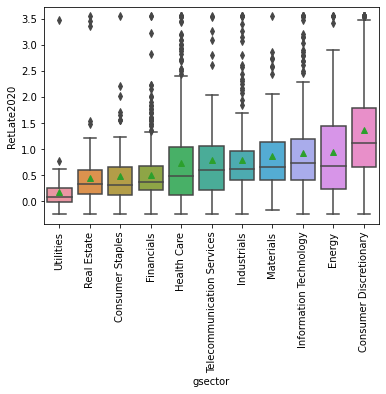

In [ ]:
# Create row order's lists
late_order = list(early_late[['gsector',
                              'RetLate2020']].groupby('gsector'
                              ).mean().sort_values(by = 'RetLate2020',
                                                   ascending= True).reset_index()['gsector'])

# Sort values with boxplot
sns.boxplot(x='gsector', y='RetLate2020', order =late_order, data=early_late, showmeans= True)
plt.xticks(rotation=90);

### Ggroup

In [ ]:
early_late_g = stock_raw[['tic', 'ggroup', 'RetEarly2020', 'RetLate2020']]

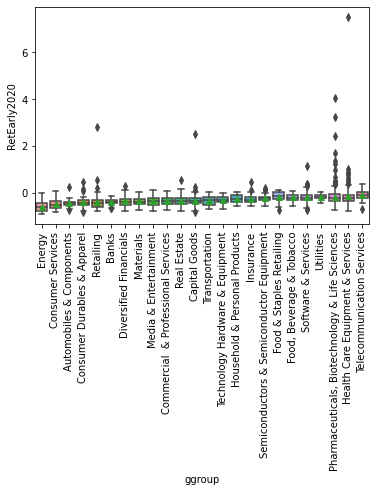

In [ ]:
# Before winsorization

# Create row order's lists
ea_order_g = list(early_late_g[['ggroup',
                              'RetEarly2020']].groupby('ggroup'
                              ).mean().sort_values(by = 'RetEarly2020',
                                                   ascending= True).reset_index()['ggroup'])

# Sort values with boxplot
sns.boxplot(x='ggroup', y='RetEarly2020', order= ea_order_g, data= early_late_g, showmeans= True)
plt.xticks(rotation=90);

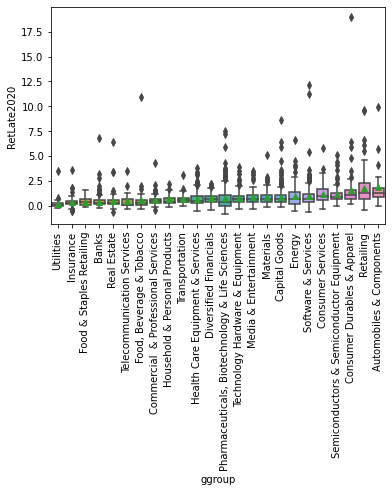

In [ ]:
# Before winsorization

# Create row order's lists
late_order_g = list(early_late_g[['ggroup',
                              'RetLate2020']].groupby('ggroup'
                              ).mean().sort_values(by = 'RetLate2020',
                                                   ascending= True).reset_index()['ggroup'])

# Sort values with boxplot
sns.boxplot(x='ggroup', y='RetLate2020', order =late_order_g, data=early_late_g, showmeans= True)
plt.xticks(rotation=90);

In [ ]:
# winsorization
early_late_g['RetEarly2020'] = winsorize(early_late_g['RetEarly2020'], limits=(0.01, 0.01))
early_late_g['RetLate2020'] = winsorize(early_late_g['RetLate2020'], limits=(0.02, 0.02))

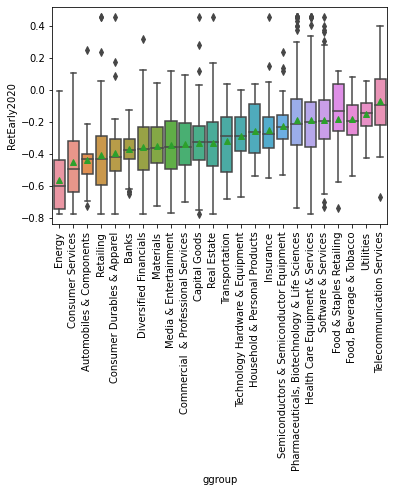

In [ ]:
# After winsorization

# Create row order's lists
ea_order_g = list(early_late_g[['ggroup',
                              'RetEarly2020']].groupby('ggroup'
                              ).mean().sort_values(by = 'RetEarly2020',
                                                   ascending= True).reset_index()['ggroup'])

# Sort values with boxplot
sns.boxplot(x='ggroup', y='RetEarly2020', order= ea_order_g, data= early_late_g, showmeans= True)
plt.xticks(rotation=90);

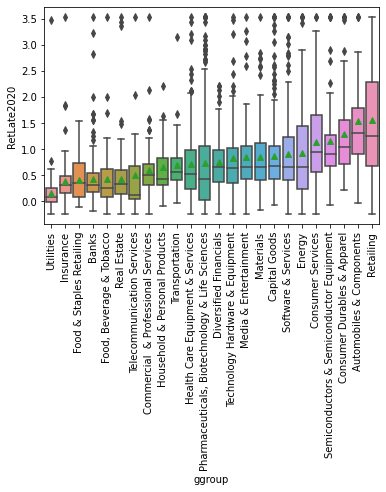

In [ ]:
# After winsorization

# Create row order's lists
late_order_g = list(early_late_g[['ggroup',
                              'RetLate2020']].groupby('ggroup'
                              ).mean().sort_values(by = 'RetLate2020',
                                                   ascending= True).reset_index()['ggroup'])

# Sort values with boxplot
sns.boxplot(x='ggroup', y='RetLate2020', order =late_order_g, data=early_late_g, showmeans= True)
plt.xticks(rotation=90);

### Best method for Industry

In [ ]:
# sic

# Get dummy variables
dummy_early_late = pd.get_dummies(early_late_sic, columns=['sic'])

# Fixed effect: Check if industry matters on ReturnEarly2020

# define x as a subset of original dataframe
x = dummy_early_late.drop(columns=['RetEarly2020', 'RetLate2020', 'tic'])
# define y as a series
y = dummy_early_late['RetEarly2020']

# pass x as a dataframe, while pass y as a series
print(f'Adjust r square for ReturnEarly2020 by sic is {round(sm.OLS(y, x).fit().rsquared_adj, 2)}.')

# Fixed effect: Check if industry matters on ReturnLate2020

# define x as a subset of original dataframe
x2 = dummy_early_late.drop(columns=['RetEarly2020', 'RetLate2020', 'tic'])
# define y as a series
y2 = dummy_early_late['RetLate2020']

# pass x as a dataframe, while pass y as a series
print(f'Adjust r square for ReturnLate2020 by sic is {round(sm.OLS(y2, x2).fit().rsquared_adj, 2)}.')

Adjust r square for ReturnEarly2020 by sic is 0.09.
Adjust r square for ReturnLate2020 by sic is 0.09.


In [ ]:
# naics

# Get dummy variables
dummy_early_late = pd.get_dummies(early_late_na, columns=['naics'])

# Fixed effect: Check if industry matters on ReturnEarly2020

# define x as a subset of original dataframe
x = dummy_early_late.drop(columns=['RetEarly2020', 'RetLate2020', 'tic'])
# define y as a series
y = dummy_early_late['RetEarly2020']

# pass x as a dataframe, while pass y as a series
print(f'Adjust r square for ReturnEarly2020 by naics is {round(sm.OLS(y, x).fit().rsquared_adj, 2)}.')

# Fixed effect: Check if industry matters on ReturnLate2020

# define x as a subset of original dataframe
x2 = dummy_early_late.drop(columns=['RetEarly2020', 'RetLate2020', 'tic'])
# define y as a series
y2 = dummy_early_late['RetLate2020']

# pass x as a dataframe, while pass y as a series
print(f'Adjust r square for ReturnLate2020 by naics is {round(sm.OLS(y2, x2).fit().rsquared_adj, 2)}.')

Adjust r square for ReturnEarly2020 by naics is 0.12.
Adjust r square for ReturnLate2020 by naics is 0.1.


In [ ]:
# gsector

# Get dummy variables
dummy_early_late = pd.get_dummies(early_late, columns=['gsector'])

# Fixed effect: Check if industry matters on ReturnEarly2020

# define x as a subset of original dataframe
x = dummy_early_late.drop(columns=['RetEarly2020', 'RetLate2020', 'tic'])
# define y as a series
y = dummy_early_late['RetEarly2020']

# pass x as a dataframe, while pass y as a series
print(f'Adjust r square for ReturnEarly2020 by gesector is {round(sm.OLS(y, x).fit().rsquared_adj, 2)}.')

# Fixed effect: Check if industry matters on ReturnLate2020

# define x as a subset of original dataframe
x2 = dummy_early_late.drop(columns=['RetEarly2020', 'RetLate2020', 'tic'])
# define y as a series
y2 = dummy_early_late['RetLate2020']

# pass x as a dataframe, while pass y as a series
print(f'Adjust r square for ReturnLate2020 by gesector is {round(sm.OLS(y2, x2).fit().rsquared_adj, 2)}.')

Adjust r square for ReturnEarly2020 by gesector is 0.19.
Adjust r square for ReturnLate2020 by gesector is 0.12.


In [ ]:
# ggroup

# Get dummy variables
dummy_early_late = pd.get_dummies(early_late_g, columns=['ggroup'])

# Fixed effect: Check if industry matters on ReturnEarly2020

# define x as a subset of original dataframe
x = dummy_early_late.drop(columns=['RetEarly2020', 'RetLate2020', 'tic'])
# define y as a series
y = dummy_early_late['RetEarly2020']

# pass x as a dataframe, while pass y as a series
print(f'Adjust r square for ReturnEarly2020 by ggroup is {round(sm.OLS(y, x).fit().rsquared_adj, 2)}.')

# Fixed effect: Check if industry matters on ReturnLate2020

# define x as a subset of original dataframe
x2 = dummy_early_late.drop(columns=['RetEarly2020', 'RetLate2020', 'tic'])
# define y as a series
y2 = dummy_early_late['RetLate2020']

# pass x as a dataframe, while pass y as a series
print(f'Adjust r square for ReturnLate2020 by ggroup is {round(sm.OLS(y2, x2).fit().rsquared_adj, 2)}.')

Adjust r square for ReturnEarly2020 by ggroup is 0.21.
Adjust r square for ReturnLate2020 by ggroup is 0.14.


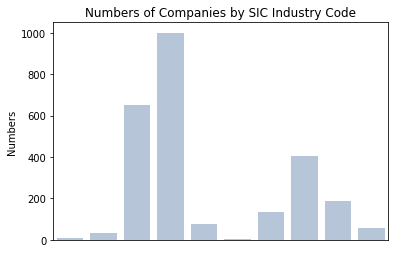

In [ ]:
# Numbers of Companies by SIC Industry Code
industry_number = stock_raw.copy()
sic_ind = industry_number.groupby('sic').count().reset_index()[['sic','tic']]
sic_ind = sic_ind.rename(columns={'tic': 'Numbers'})
plot = sns.barplot(x = 'sic', y = 'Numbers', data = sic_ind, color= 'lightsteelblue')
plot
plt.xticks(rotation=90)
plt.title('Numbers of Companies by SIC Industry Code')
plot.axes.get_xaxis().set_visible(False)
plt.savefig('SIC.jpeg');

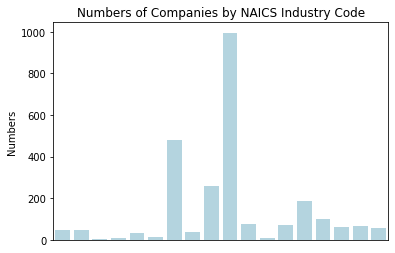

In [ ]:
# Numbers of Companies by NAICS Industry Code
industry_number = stock_raw.copy()
naics_ind = industry_number.groupby('naics').count().reset_index()[['naics','tic']]
naics_ind = naics_ind.loc[naics_ind['naics'] != 99]
naics_ind = naics_ind.rename(columns={'tic': 'Numbers'})
plot = sns.barplot(x = 'naics', y = 'Numbers', data = naics_ind, color= 'lightblue')
plot
plt.xticks(rotation=90)
plot.axes.get_xaxis().set_visible(False)
plt.title('Numbers of Companies by NAICS Industry Code')
plt.savefig('NAICS.jpeg');

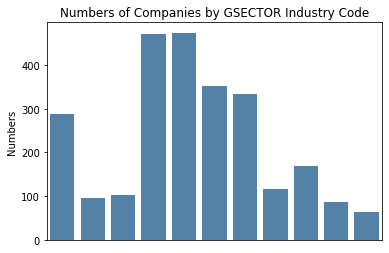

In [ ]:
# Numbers of Companies by GSECTOR Industry Code
industry_number = stock_raw.copy()
gsector_ind = industry_number.groupby('gsector').count().reset_index()[['gsector','tic']]
gsector_ind = gsector_ind.rename(columns={'tic': 'Numbers'})
plot = sns.barplot(x = 'gsector', y = 'Numbers', data = gsector_ind, color= 'steelblue')
plot
plt.xticks(rotation=90)
plot.axes.get_xaxis().set_visible(False)
plt.title('Numbers of Companies by GSECTOR Industry Code')
plt.savefig('GSECTOR.jpeg');

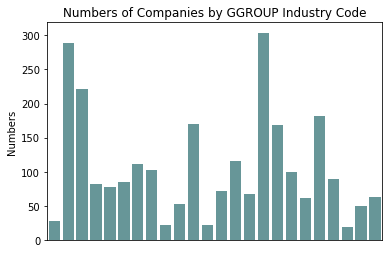

In [ ]:
# Numbers of Companies by GGROUP Industry Code
industry_number = stock_raw.copy()
ggroup_ind = industry_number.groupby('ggroup').count().reset_index()[['ggroup','tic']]
ggroup_ind = ggroup_ind.rename(columns={'tic': 'Numbers'})
plot = sns.barplot(x = 'ggroup', y = 'Numbers', data = ggroup_ind, color= 'cadetblue')
plot
plt.xticks(rotation=90)
plot.axes.get_xaxis().set_visible(False)
plt.title('Numbers of Companies by GGROUP Industry Code')
plt.savefig('GGROUP.jpeg');

Given that Gsector possess the second highest adjust-r-square, best distribution of companies across industries, and the most reasonable numbers of industries, we select gsector.

### Industry with Highest and Lowest Return

Here, we combine industries with top 2 highest and lowest stock returns in both early and late 2020 into a chart.

In [ ]:
avg_stock_ret_ea = early_late[['gsector', 'RetEarly2020']].groupby('gsector').mean()
avg_stock_ret_lat = early_late[['gsector', 'RetLate2020']].groupby('gsector').mean()

# Select top 5 industries with highest return in early 2020
top = avg_stock_ret_ea.sort_values(by = ['RetEarly2020'], ascending =False).head(2)
top['RetEarly2020'] = round(top['RetEarly2020'], 2)

# Select top 5 industries with lowest return in early 2020
last = avg_stock_ret_ea.sort_values(by = ['RetEarly2020'], ascending= True).head(2)
last['RetEarly2020'] = round(last['RetEarly2020'], 2)

# Select top 5 industries with highest return in late 2020
top2 = avg_stock_ret_lat.sort_values(by = ['RetLate2020'], ascending =False).head(2)
top2['RetLate2020'] = round(top2['RetLate2020'], 2)

# Select top 5 industries with lowest return in late 2020
last2 = avg_stock_ret_lat.sort_values(by = ['RetLate2020'], ascending= True).head(2)
last2['RetLate2020'] = round(last2['RetLate2020'], 2)

# Rename the columns to differentiate returns
top = top.rename(columns = {'RetEarly2020': 'RetEarly2020_High'})
last = last.rename(columns = {'RetEarly2020': 'RetEarly2020_Low'})
top2 = top2.rename(columns = {'RetLate2020': 'RetLate2020_High'})
last2 = last2.rename(columns = {'RetLate2020': 'RetLate2020_Low'})

# Merge all datasets together
a = pd.merge(top, last, on ='gsector', how = 'outer')
b = pd.merge(a, top2, on ='gsector', how = 'outer')
c = pd.merge(b, last2, on ='gsector', how = 'outer')

# Replace value with icons to make the entire table readable
c['RetEarly2020_High'] = c['RetEarly2020_High'].fillna(0)
c['RetEarly2020_High'] = np.where(c['RetEarly2020_High'] != 0, 'v', '')
c['RetEarly2020_Low'] = c['RetEarly2020_Low'].fillna(0)
c['RetEarly2020_Low'] = np.where(c['RetEarly2020_Low'] != 0, 'v', '')
c['RetLate2020_High'] = c['RetLate2020_High'].fillna(0)
c['RetLate2020_High'] = np.where(c['RetLate2020_High'] != 0, 'v', '')
c['RetLate2020_Low'] = c['RetLate2020_Low'].fillna(0)
c['RetLate2020_Low'] = np.where(c['RetLate2020_Low'] != 0, 'v', '')

c

,RetEarly2020_High,RetEarly2020_Low,RetLate2020_High,RetLate2020_Low
gsector,,,,
Utilities,v,,,v
Health Care,v,,,
Energy,,v,v,
Consumer Discretionary,,v,v,
Real Estate,,,,v


*   Utilities industry has relative high stock return in early 2020 but low stock return in late 2020, giving a sign of low Beta value.
*   Energy and Consumer Discertionary has relative low stock return in early 2020 but high stock return in late 2020, giving a sign of high Beta value.
*   Health Care performed relatively well in early 2020, showing stronger stabilitiy among COVID market crash.  
*   Real Estate performed relatively well in late 2020, with a faster recovery on stock price.

## Financial Ratio

We first create financial ratio and winsorize outliers. Next, we select financial ratio based on two filters: correlation and regression. Variables with top 10 absolute correlation will pass the first filter and those shows statistical significance will pass the second filter.

### Calculate Financial Ratio

In [ ]:
stock_finance = stock_raw.copy()

In [ ]:
# Create financial ratios
stock_finance['Book/Price'] = stock_finance['ceq']/(stock_finance['prcc_c']*stock_finance['csho'])
stock_finance['Earning/Price'] = stock_finance['ni']/(stock_finance['prcc_c']*stock_finance['csho'])
stock_finance['EBIT/Price'] = stock_finance['ebit']/(stock_finance['prcc_c']*stock_finance['csho'])
stock_finance['Sales/Price'] = stock_finance['sale']/(stock_finance['prcc_c']*stock_finance['csho'])
stock_finance['Cash/Total Assets'] = stock_finance['ch']/stock_finance['at']
stock_finance['Gross Margin'] = (stock_finance['sale'] - stock_finance['cogs'])/stock_finance['sale']
stock_finance['Profit Margin'] = stock_finance['ni']/stock_finance['sale']
stock_finance['ROA'] = stock_finance['ni']/stock_finance['at']
stock_finance['ATR (Revenue)'] = stock_finance['revt']/stock_finance['at']
stock_finance['Debt Ratio'] = stock_finance['lt']/stock_finance['at']
stock_finance['Retained Earnings/Total Assets'] = stock_finance['re']/stock_finance['at']
stock_finance['EBIT/Total Assets'] = stock_finance['ebit']/stock_finance['at']
stock_finance['Account Payable/Sales'] = stock_finance['ap']/stock_finance['sale']
stock_finance['Long Term Debt/Total Assets'] = stock_finance['dltt']/stock_finance['at']
stock_finance['Sales/Employees'] = stock_finance['sale']/stock_finance['emp']

# Select useful columns
stock_finance = stock_finance[['tic', 'Book/Price', 'Earning/Price', 'EBIT/Price',
                               'Sales/Price', 'Cash/Total Assets', 'Gross Margin', 
                               'Profit Margin', 'ROA', 'ATR (Revenue)', 
                               'Debt Ratio', 'Retained Earnings/Total Assets', 
                               'EBIT/Total Assets', 'Account Payable/Sales',
                               'Long Term Debt/Total Assets', 'Sales/Employees', 'gsector',
                               'ggroup','naics','sic', 'RetEarly2020', 'RetLate2020']]

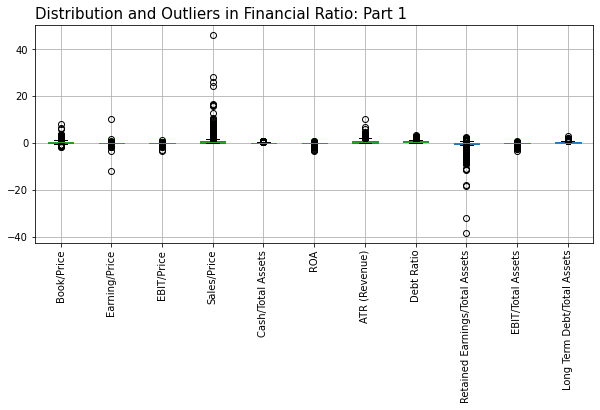

In [ ]:
# Check outliers in x variables
stock_finance.boxplot(column= ['Book/Price', 'Earning/Price', 'EBIT/Price',
                               'Sales/Price', 'Cash/Total Assets', 'ROA', 'ATR (Revenue)', 
                               'Debt Ratio', 'Retained Earnings/Total Assets', 
                               'EBIT/Total Assets',
                               'Long Term Debt/Total Assets']
               ,figsize = (10,4))

plt.xticks(rotation=90)
plt.title('Distribution and Outliers in Financial Ratio: Part 1', loc='left', fontsize = 15);

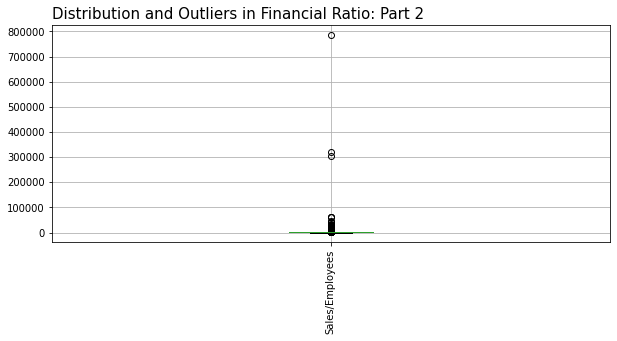

In [ ]:
# Check outliers in x variables
stock_finance.boxplot(column= ['Sales/Employees']
               ,figsize = (10,4))

plt.xticks(rotation=90)
plt.title('Distribution and Outliers in Financial Ratio: Part 2', loc='left', fontsize = 15);

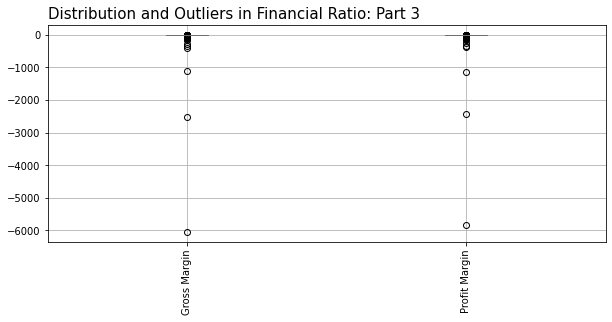

In [ ]:
# Check outliers in x variables
stock_finance.boxplot(column= ['Gross Margin', 'Profit Margin']
               ,figsize = (10,4))

plt.xticks(rotation=90)
plt.title('Distribution and Outliers in Financial Ratio: Part 3', loc='left', fontsize = 15);

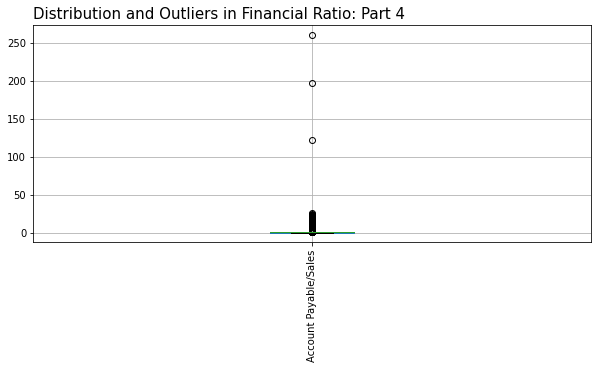

In [ ]:
# Check outliers in x variables
stock_finance.boxplot(column= ['Account Payable/Sales']
               ,figsize = (10,4))

plt.xticks(rotation=90)
plt.title('Distribution and Outliers in Financial Ratio: Part 4', loc='left', fontsize = 15);

In [ ]:
stock_finance.head(1)

,tic,Book/Price,Earning/Price,EBIT/Price,Sales/Price,Cash/Total Assets,Gross Margin,Profit Margin,ROA,ATR (Revenue),Debt Ratio,Retained Earnings/Total Assets,EBIT/Total Assets,Account Payable/Sales,Long Term Debt/Total Assets,Sales/Employees,gsector,ggroup,naics,sic,RetEarly2020,RetLate2020
0,AIR,0.570228,0.00278,0.068483,1.31994,0.194661,0.173551,0.002106,0.002116,1.004954,0.565849,0.318134,0.05214,0.091705,0.322703,386.907407,Industrials,Capital Goods,Wholesale Trade,Wholesale Trade,-0.603849,1.03941


In [ ]:
# Winsorize the variables (some at 1% and 99% values but others at 2% and 98% values)
stock_finance = stock_finance[['tic', 'Book/Price', 'Earning/Price', 'EBIT/Price',
                               'Sales/Price', 'Cash/Total Assets', 'Gross Margin', 
                               'Profit Margin', 'ROA', 'ATR (Revenue)', 
                               'Debt Ratio', 'Retained Earnings/Total Assets', 
                               'EBIT/Total Assets', 'Account Payable/Sales',
                               'Long Term Debt/Total Assets', 'Sales/Employees', 'gsector',
                               'ggroup', 'naics', 'sic','RetEarly2020', 'RetLate2020']]

stock_finance['Book/Price'] = winsorize(stock_finance['Book/Price'], limits=(0.01, 0.01))
stock_finance['Earning/Price'] = winsorize(stock_finance['Earning/Price'], limits=(0.01, 0.01))
stock_finance['EBIT/Price'] = winsorize(stock_finance['EBIT/Price'], limits=(0.01, 0.01))
stock_finance['Sales/Price'] = winsorize(stock_finance['Sales/Price'], limits=(0.01, 0.01))
stock_finance['Cash/Total Assets'] = winsorize(stock_finance['Cash/Total Assets'], limits=(0.01, 0.01))
stock_finance['Gross Margin'] = winsorize(stock_finance['Gross Margin'], limits=(0.02, 0.02))
stock_finance['Profit Margin'] = winsorize(stock_finance['Profit Margin'], limits=(0.02, 0.02))
stock_finance['ROA'] = winsorize(stock_finance['ROA'], limits=(0.01, 0.01))
stock_finance['ATR (Revenue)'] = winsorize(stock_finance['ATR (Revenue)'], limits=(0.01, 0.01))
stock_finance['Debt Ratio'] = winsorize(stock_finance['Debt Ratio'], limits=(0.01, 0.01))
stock_finance['Retained Earnings/Total Assets'] = winsorize(stock_finance['Retained Earnings/Total Assets'],
                                                            limits=(0.01, 0.01))
stock_finance['EBIT/Total Assets'] = winsorize(stock_finance['EBIT/Total Assets'], limits=(0.01, 0.01))
stock_finance['Account Payable/Sales'] = winsorize(stock_finance['Account Payable/Sales'], limits=(0.02, 0.02))
stock_finance['Long Term Debt/Total Assets'] = winsorize(stock_finance['Long Term Debt/Total Assets'],
                                                         limits=(0.01, 0.01))
stock_finance['Sales/Employees'] = winsorize(stock_finance['Sales/Employees'], limits=(0.02, 0.02))

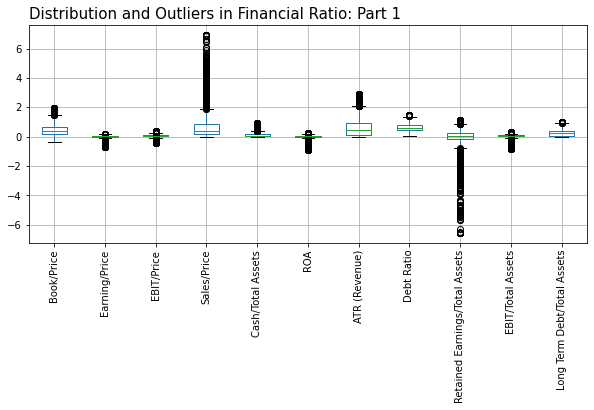

In [ ]:
# Check outliers in x variables after winsorization
stock_finance.boxplot(column= ['Book/Price', 'Earning/Price', 'EBIT/Price',
                               'Sales/Price', 'Cash/Total Assets', 'ROA', 'ATR (Revenue)', 
                               'Debt Ratio', 'Retained Earnings/Total Assets', 
                               'EBIT/Total Assets',
                               'Long Term Debt/Total Assets']
               ,figsize = (10,4))

plt.xticks(rotation=90)
plt.title('Distribution and Outliers in Financial Ratio: Part 1', loc='left', fontsize = 15);

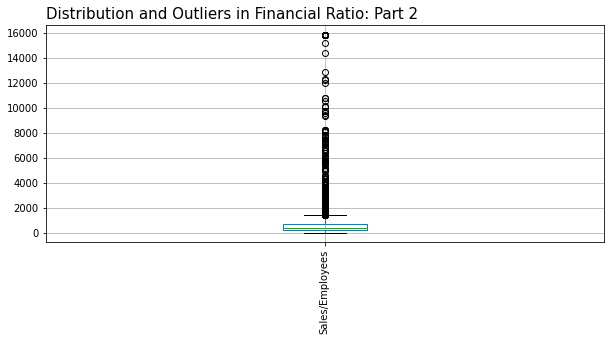

In [ ]:
# Check outliers in x variables after winsorization
stock_finance.boxplot(column= ['Sales/Employees']
               ,figsize = (10,4))

plt.xticks(rotation=90)
plt.title('Distribution and Outliers in Financial Ratio: Part 2', loc='left', fontsize = 15);

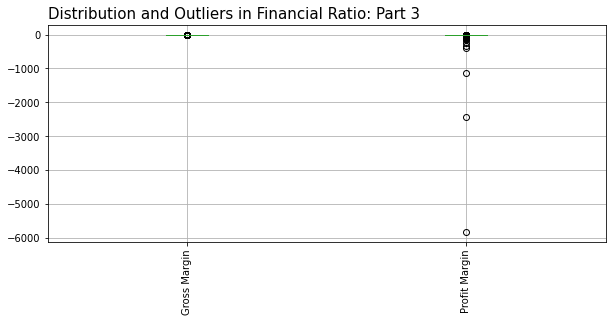

In [ ]:
# Check outliers in x variables after winsorization
stock_finance.boxplot(column= ['Gross Margin', 'Profit Margin']
               ,figsize = (10,4))

plt.xticks(rotation=90)
plt.title('Distribution and Outliers in Financial Ratio: Part 3', loc='left', fontsize = 15);

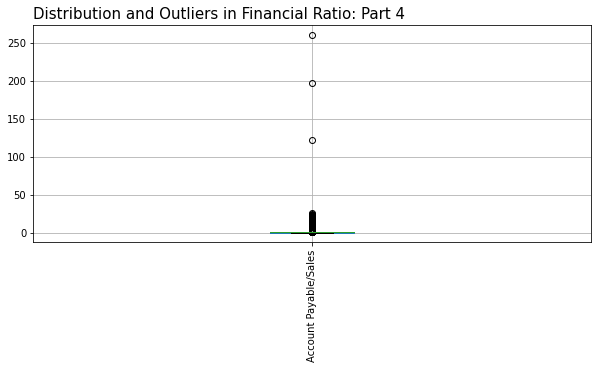

In [ ]:
 # Check outliers in x variables after winsorization
stock_finance.boxplot(column= ['Account Payable/Sales']
               ,figsize = (10,4))

plt.xticks(rotation=90)
plt.title('Distribution and Outliers in Financial Ratio: Part 4', loc='left', fontsize = 15);

In [ ]:
# As null values and/or infinite values emerge when creating ratios, we drop them to proceed our analysis
print(stock_finance.shape)
stock_finance.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_finance.dropna(inplace = True)
print(stock_finance.shape)

(2551, 22)
(2465, 22)


### Select Variables with Top 10 Absolute Correlation Value and Regression

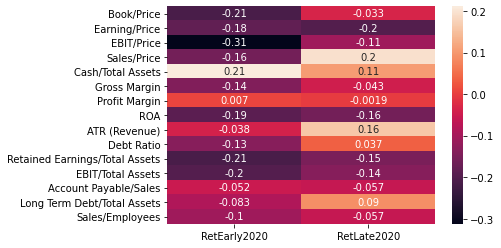

In [ ]:
# Correlation Analysis
corrMatrix = stock_finance.corr()
sns.heatmap(corrMatrix.iloc[:-2, -2:], annot= True)
plt.show()

Heatmap above demonstrates correlation between financial ratio and stock return.

#### Return Early

**Filter 1: Absolute Correlation**

In [ ]:
# Variables with top 10 absolute correlation with ReturnEarly2020
corrMatrix_early = corrMatrix.iloc[:-2, -2].sort_values(ascending = False, key=abs)
corrMatrix_early 

EBIT/Price                       -0.312242
Book/Price                       -0.211725
Retained Earnings/Total Assets   -0.211207
Cash/Total Assets                 0.211198
EBIT/Total Assets                -0.196552
ROA                              -0.187546
Earning/Price                    -0.179779
Sales/Price                      -0.157249
Gross Margin                     -0.141678
Debt Ratio                       -0.133299
Sales/Employees                  -0.104689
Long Term Debt/Total Assets      -0.083273
Account Payable/Sales            -0.051772
ATR (Revenue)                    -0.037552
Profit Margin                     0.006980
Name: RetEarly2020, dtype: float64

**Filter 2: Regression**

In [ ]:
# Regression for Return Early

X_early = stock_finance[list(corrMatrix_early.reset_index().iloc[:10,0])]
y_early = stock_finance['RetEarly2020']

# Use OLS
X_early = sm.add_constant(X_early)
n1_model = sm.OLS(y_early,X_early)
n1_results = n1_model.fit()
print(n1_results.summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     35.93
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           3.98e-66
Time:                        08:28:18   Log-Likelihood:                -492.67
No. Observations:                2465   AIC:                             1007.
Df Residuals:                    2454   BIC:                             1071.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Equation for return early is as follows:
```
# Return Early = -0.15*** - 0.46*** EBIT/Price - 0.10*** Book/Price - 0.03*** Retained Earnings/Total Assets + 0.05 Cash/Total Assets 
# -0.07 EBIT/Total Asssets + 0.17 ROA - 0.22* Earning/Price - 0.01** Sales/Price + 0.00** Gross Margin - 0.11* Debt Ratio
```

We only consider variables with significant difference and those without 0 coefficient. EBIT/Price, Book/Price, Retained Earnings/Total Assets, Earning/Price, Sales/Price, andd Debt Ratio are selected for further analysis. All variables have a negative coefficient, which means they are all negatively correlated with return early. More explanation about whether these make economic sense are as follows:



*  EBIT/Price and Earning/Price: Earning before income tax divided by price and earning by price. Higher EBIT/Price and higher Earning/Price stands for higher relative earnings for companies, which is a good sign and may be positively correlated with stock return in an ideal situation. Negative correlation here does not make economic sense.

*   Book/Price: Book value divided by price. Higher Book/Price means relatively higher book value for companies, which is a good sign and may be positively correlated with stock return in an ideal situation. Negative correlation here does not make economic sense.

*   Retained Earnings/Price: Retained Earning divided by price. Higher Retain Earnings/Price means relatively higher retained earnings for companies, which is a good sign and may be positively correlated with stock return in an ideal situation. Negative correlation here does not make economic sense.

*   Sales/Price: Sales divided by price. Higher Sales/Price means relatively higher sales for companies, which may be a good sign and may be positively correlated with stock return in an ideal situation. Negative correlation here does not make economic sense.

*   Debt Ratio: Total Liabilities/Total Assets. Higher debt ratio means relatively higher liabilities for companies, which may be a bad sign and may be negatively correlated with stock return in an ideal situation. Negative correlation here makes economic sense.

#### Return Late

**Filter 1: Absolute Correlation**

In [ ]:
# Variables with top 10 absolute correlation with ReturnLate2020
corrMatrix_late = corrMatrix.iloc[:-2, -1].sort_values(ascending = False, key=abs)
corrMatrix_late

Earning/Price                    -0.198488
Sales/Price                       0.196554
ATR (Revenue)                     0.161440
ROA                              -0.158702
Retained Earnings/Total Assets   -0.148770
EBIT/Total Assets                -0.136167
Cash/Total Assets                 0.105975
EBIT/Price                       -0.105318
Long Term Debt/Total Assets       0.090248
Account Payable/Sales            -0.057474
Sales/Employees                  -0.057098
Gross Margin                     -0.042619
Debt Ratio                        0.036691
Book/Price                       -0.032564
Profit Margin                    -0.001865
Name: RetLate2020, dtype: float64

**Filter 2: Regression**

In [ ]:
# Regression for Return Late

X_late = stock_finance[list(corrMatrix_late.reset_index().iloc[:10,0])]
y_late = stock_finance['RetLate2020']

# Use OLS
X_late = sm.add_constant(X_late)
n2_model = sm.OLS(y_late,X_late)
n2_results = n2_model.fit()
print(n2_results.summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     25.27
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           4.49e-46
Time:                        08:28:18   Log-Likelihood:                -3579.7
No. Observations:                2465   AIC:                             7181.
Df Residuals:                    2454   BIC:                             7245.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

Equation for return late is as follows:
```
# Return Late = -0.48*** - 1.09*** Earning/Price + 0.13*** Sales/Price + 0.21*** ATR (Revenue) + 0.79 ROA - 0.08* Retained Earnings/Total Assets 
# - 1.14* EBIT/Total Assets + 0.42* Cash/Total Assets + 0.17 EBIT/Price + 0.26* Long Term Debt/Total Assets + 0.00 Account Payable/Sales 
```



We only consider variables with significant difference and those without 0 coefficient. Earning/Price, Sales/Price, ATR (Revenue), Retained Earnings/Total Assets, EBIT/Total Assets, Cash/Total Assets, and Long Term Debt/Total Assets are selected for further analysis.

Among selected variables, some have positive correlation with late stock return while other have negative. We will further explain whether these are logically at an economic perspective.

*   Earning/Price : Earning divided by price. Ideally, it should be positively correlated with stock return as higher Earning/Price means higher relative earnings. However, it is negatively correlated with stock return here,  which may be abnormal.

*   Sales/Price: Sales divded by price. Ideally, it should be positively correlated with stock return as higher Sales/Price means relatively higher earnings. Correlation here is positive, which makes economic sense.

*   ATR (Revenue): Asset turnover ratio, which is total revenue divided by total asset. It could measure how much the company rely on assets to generate value. For this case, it is hard to find ideal correlation between ATR and stock return as ATR reflects different types of companies. 

*   Retained Earnings/Total Assets: This is a way to measure companies leverage as companies with low retained earning by total asset means they prefer to borrow more money for investments. As companies with high leverage may be hard to survive during economic downturn (though the stock already bounced-up dramatically), Retained Earnings/Total Assets should be positively correlated with stock return ideally. However, reality does not matches our hypothesis.

*   EBIT/Total Assets: EBIT divided by price. Ideally, it should be positively correlated with stock return as higher EBIT/Total Assets means higher relative earnings. However, it is negatively correlated with stock return here, which may be abnormal. 

*   Cash/Total Assets: Cash divided by total assets. Ideally, it should be positively correlated with stock return as higher cash divided by total assets means higher relative cash. Reality matches our hypothesis.

*   Long Term Debt/Total Assets: Long term debt divided by total assets. Ideally, it should be negatively correlated with stock return as investors may shy away from companies with higher relative long-term debt. However, the result here differs from our hypothesis.

## Industry Break-down

In previous sections, we have grouped companies into different industries and select financial ratio that shows significant difference. Though some correlation between financial ratio and stock return may not make economic sense, we will still proceed those variables to our next analysis as our measurement on the economic perspective are merely hypothesis.

For this part, we check whether correlation between financial ratio and stock return in general may appear in the same way at the industry level. We measure these by Return Early and Return Late respectively.

**Return Early**

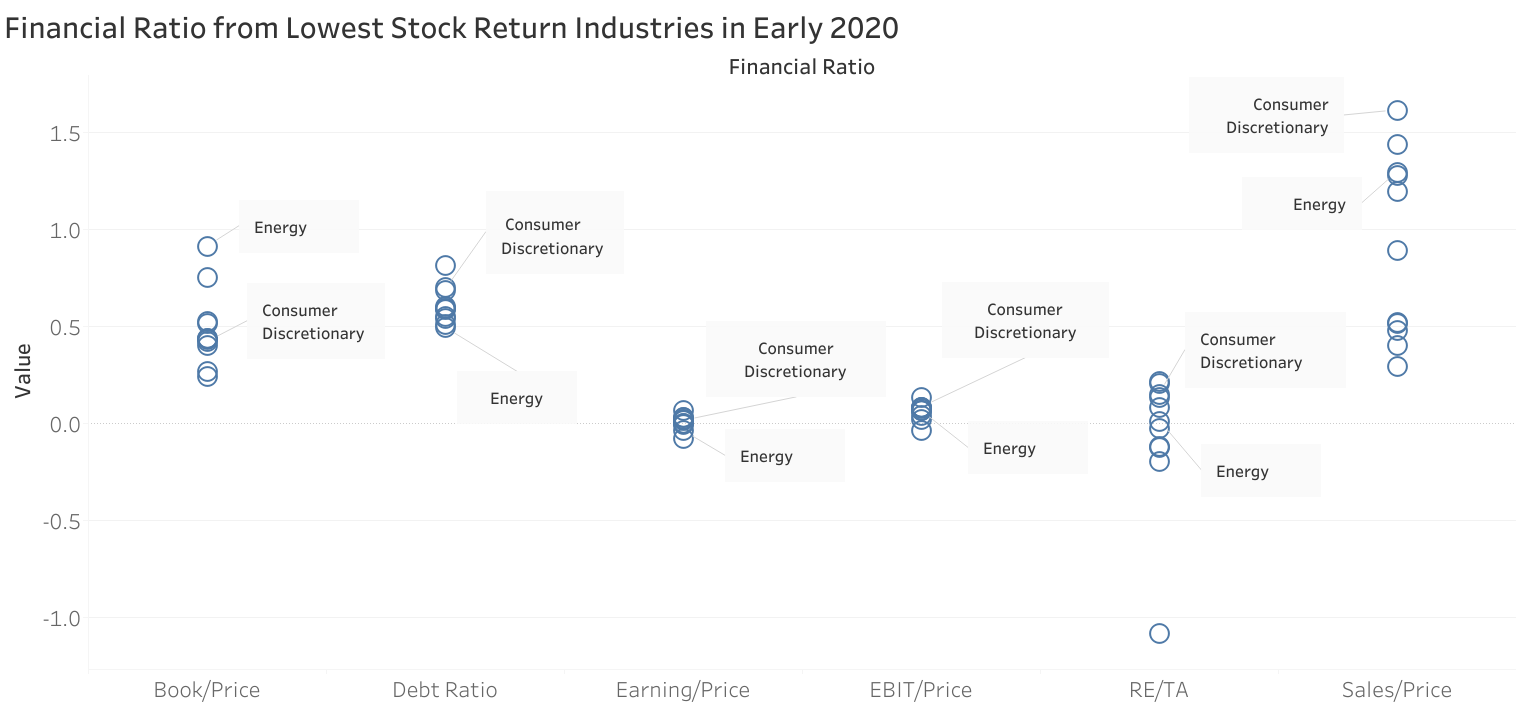

Figure above presents financial ratios from lowest stock return industries in early 2020. Ideally, based on the fact that all ratios are negatively correlated with return early 2020, financial ratios of industries with lowest stock return should be the highest. However, this only appears in few senarios, pointing out that correlations of ratio still varies across industries.

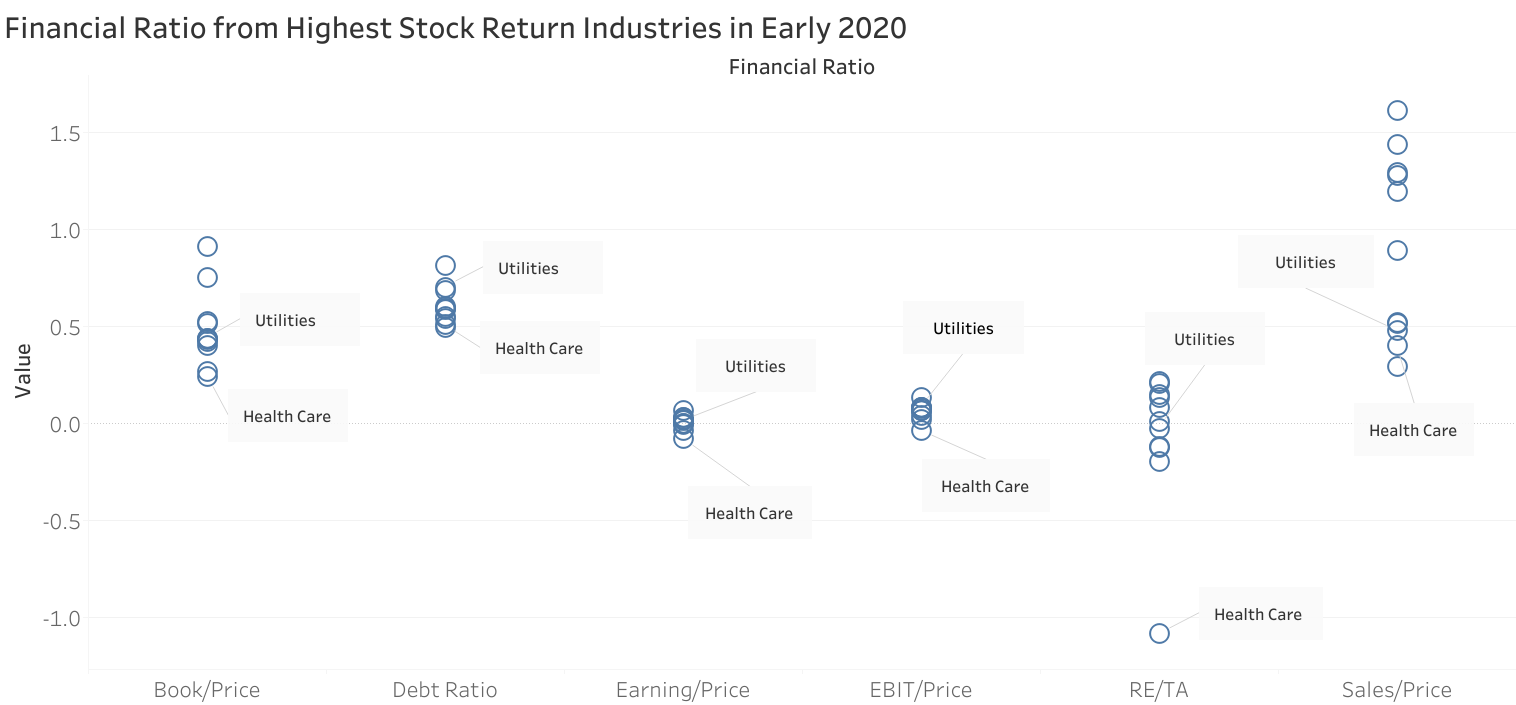

Figure above presents financial ratios from highest stock return industries in early 2020. Ideally, based on the fact that all ratios are negatively correlated with return early 2020, financial ratios of industries with highest stock return should be the lowest. This apply to health industry while does not suit Utility industry. Stock performance of Utility industry are possibly mainly driven by other factors.

**Return Late**

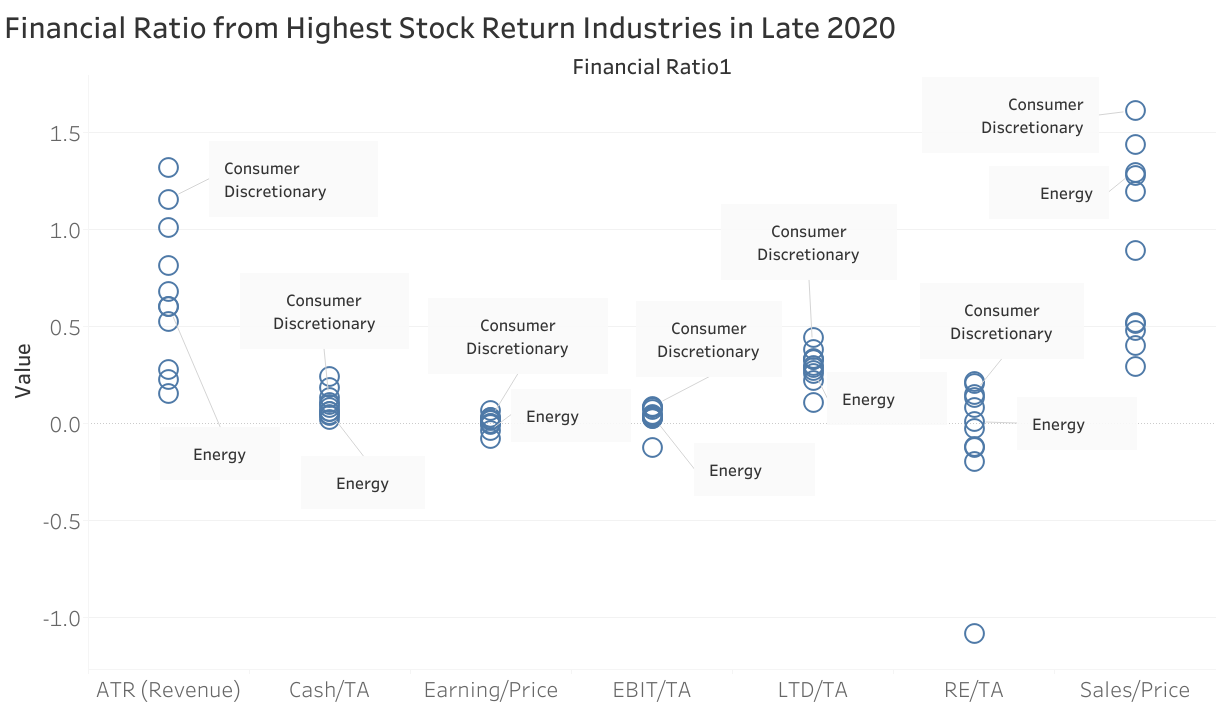

Based on results from previous regression, companies with high stock return should have low Earning/Price, Retained Earning/Total Assets, and EBIT/Total assets while should have high Sales/Price, Asseet Turnover Ratio, Cash/Total Assets, and Long Term Liabilities/Totla Assets. However, we only could see Consumer Discretionary industry has high values across all ratios while Energy industry has moderate values.

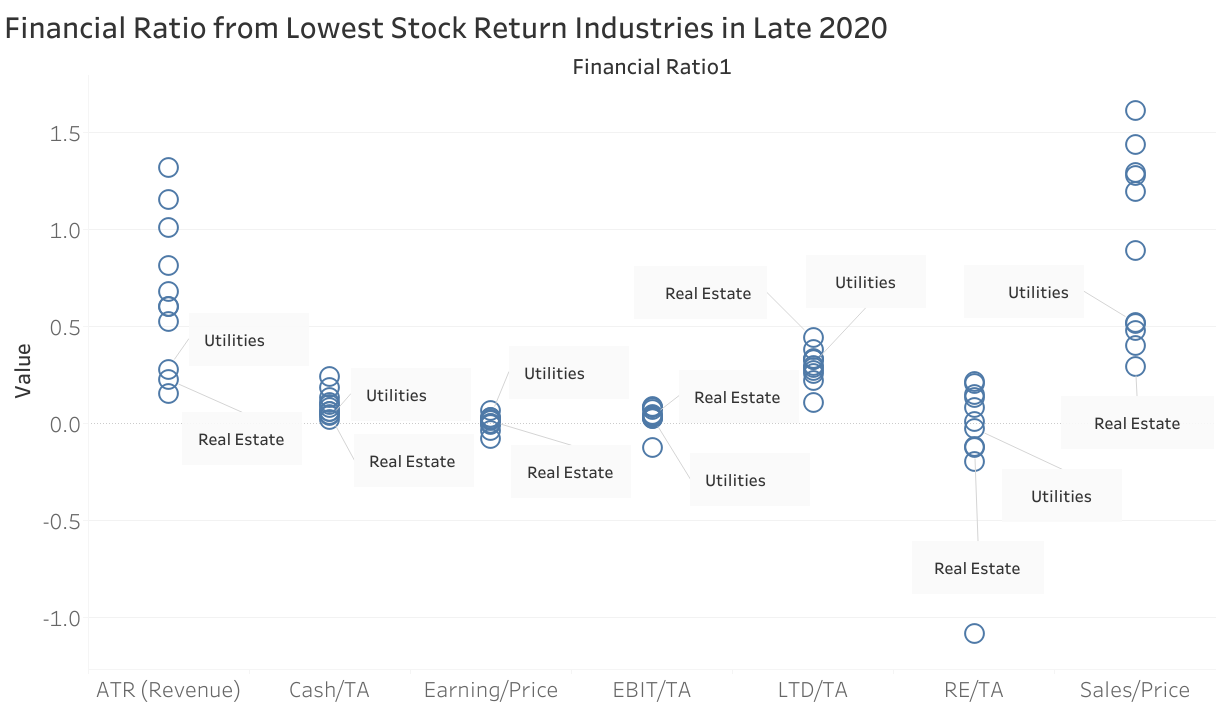

Based on results from previous regression, companies with low stock return should have high Earning/Price, Retained Earning/Total Assets, and EBIT/Total assets while should have low Sales/Price, Asseet Turnover Ratio, Cash/Total Assets, and Long Term Liabilities/Totla Assets. However, the result above is inconsistent with those from regression.

## Key takeaways

General: Correlation Between Stock Return in 2020 and Financial Ratio in 2019
*   Not all makes economic sense
*   Low interpretability: investor trade stocks based on other factors
*   Investors who make decision based on 2019 financial data: they may believe financial health changes dramatically under COVID


Inudstry-level: Correlation Between Stock Return in 2020 and Financial Ratio in 2019

*   Correlation between stock return and financial ratio in general only applies to some industries.

*   Health Industry
      - Poor financial health: low Book Price, Earning/Price, EBIT/Price, Retained Earnings/Total Assets, and Sales/Price
      - High stock return in early 2020
      - Hypothesis: High market demand under pandemic, investors are more confident with future financial health

*   Consumer Discretionary
      - Stronger financial health: high Earning/Price, EBIT/Price, Retained Earnings/Total Assets, and Sales/Price
      - Low stock return in early 2020
      - Hpythoesis: Very low market demand under pandemic, investors are less confident with future financial health

Limitations: Due to lack of sufficient data regarding balance sheets and cash flow statements, we measure financial health here merely based on few financial ratios, which may not reflect real financial health in industries.
